<a href="https://colab.research.google.com/github/NSArt1/StatPrac25/blob/main/Pix2PixPresentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GAN`s. Pix2Pix-architecture
Conditional image to image generation


In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## Generative modeling



<p align="center">
  <img src="https://drive.google.com/uc?id=1vUpg780cuwD6f_MUul6rF80WCq_GWncP" alt="описание" width="1600">
</p>

Let $p(x)$  $\sim $ $X_{data} $ \\
             $\hat p(\hat x)$ $\sim X_{fake}$, $\hat x = G(z)$, where $z$ $\sim$ $\mathcal{N}(0, 1)$ or some other simple distribution
             \\
             Task: Train $G(z)$, so that $\hat p(\hat x)$ $\sim X_{real}$

##What is GAN?


![my](https://drive.google.com/uc?id=1Mc-U_oMD5A5gCIedHDf90Gz-5om2SgKS)

More formally:

![aa](https://drive.google.com/uc?id=1sndWc4sshiPOGSzSrzUU3cwnxo_cnouo)

## Loss-function and Training

Basically we want:
$$\underset{\theta}{\min} \underset{\phi}{\max} \mathbb E_{x \sim p_{data}(x)} \log D_{\phi} (x) + \mathbb E_{z \sim p(z)} \left[  1 - \log D_{\phi} (G_{\theta}(z)) \right]$$

$$ L_{GAN} = L_{\theta ,\phi} = -\underset{\theta}{\max} \underset{\phi}{\min} \mathbb E_{x \sim p_{data}(x)} \log D_{\phi} (x) + \mathbb E_{z \sim p(z)} \left[  1 - \log D_{\phi} (G_{\theta}(z)) \right]$$

With frozen parameters of generator the minimum of cross-entropy is achieved on folowing function: $$ D_{\phi^{*}} = \frac {p(x)}{p(x)+q(x)}$$

If we place optimal discriminator in loss-function, we get loss function which minimizes generator($\mathcal D_{\theta}$) loss:
$$\mathcal D_\theta = \max_{\phi} \mathcal{L}_{\theta, \phi}
= \mathbb{E}_{x \sim p(x)} \left[ \log D_{\phi^{\ast}}(x) \right] + \mathbb{E}_{x \sim q(x)} \log \left[ 1 - D_{\phi^{\ast}}(x) \right]
= \mathbb{E}_{x \sim p(x)} \left[ \log \frac{p(x)}{p(x) + q(x)} \right] + \mathbb{E}_{x \sim q(x)} \log \left[ 1 - \frac{p(x)}{p(x) + q(x)} \right]
= \int p(x) \log \frac{p(x)}{p(x) + q(x)} \, dx + \int q(x) \log \frac{q(x)}{p(x) + q(x)} \, dx
$$

$$\mathcal D_\theta = - \log 4 + \int p(x) \log \frac{2p(x)}{p(x) + q(x)} \, dx + \int q(x) \log \frac{2q(x)}{p(x) + q(x)} \, dx
= - \log 4 + \text{KL} \left( p \ \bigg\| \frac{p + q}{2} \right) + \text{KL} \left( q \ \bigg\| \frac{p + q}{2} \right)
= - \log 4 + 2 \cdot \text{JSD}(p \ \big\| q)$$

##Conditional GAN`s

![a](https://drive.google.com/uc?id=1S0Ki03A-c8AlvN_O_O99WHXh5WeQFloT)

Basic ideas:
* Concatenation of condition and a random noise
* input the condition not only in generator, but also in discriminator
* $ \mathcal L_{cGAN} = - (\mathbb E_{x,y} \log D (x,y) + \mathbb E_{x,z} \left[  1 - \log D_{x,z} (x,G(x,z)) \right])$

## Pix2Pix

### Objective: Generate image from the input image condition

![mm](https://drive.google.com/uc?id=1OKLsRAkmnqRnfuOENI49iJgvEzxLyGCR)

### Loss-func

$$\mathcal L = \mathcal L_{cGAN}+\lambda * \mathcal L_{L1}(G)$$

![aa](https://drive.google.com/uc?id=19ZfZUhpZxckIFvAvqKRCjj4m4veA3NO4)

Some extra: as was shown adding Gaussian Noise $z$ as input to the generator with $x$ condition is ineffective, because generator simply learned to ignore it. So in Pix2Pix model noise is provided by dropout.

### Generator architecture: Unet

![aa](https://drive.google.com/uc?id=1STIyacqt9ugrQ4iF8eHsxxbzGvJ1VTJu)

Here's my implementation
```python
class DownSampleBlock(nn.Module):
    def __init__(self, in_channels, out_channels, dropout=0.1):
        super().__init__()

        self.conv_block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, stride=1, padding=1), ##doesnt change HxW, only add channels
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2),
            nn.Conv2d(out_channels, out_channels, 3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2),
        )
        self.dropout = nn.Dropout(dropout)
        self.maxpool = nn.MaxPool2d(2)

    def forward(self, x):
        res = self.conv_block(x)
        x = self.maxpool(res)
        x = self.dropout(x)

        return res, x

class UpSampleBlock(nn.Module):
    def __init__(self, in_channels, out_channels, dropout=0.1):
        super().__init__()
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)
        self.dropout = nn.Dropout(dropout)
        self.conv_block = nn.Sequential(
            nn.Conv2d(in_channels, in_channels // 2, 3, stride=1, padding=1),
            nn.BatchNorm2d(in_channels // 2),
            nn.ReLU(),
            nn.Conv2d(in_channels // 2, out_channels, 3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

    def forward(self, x, y):
        x = self.upsample(x)
        x = self.dropout(x)
        # print("Inside UpSample: ", x.shape, y.shape)
        x = torch.cat((x, y), dim = 1) #concat by channels
        # print("Inside UpSample: ", x.shape, y.shape)
        x = self.conv_block(x)
        # print("x.shape Inside UpSample: ", x.shape)
        return x

class UNet(nn.Module):
    def __init__(self, depth=5, d=64, dropout=0.1):
        super().__init__()

        self.depth = depth
        self.dropout = dropout

        self.down_depth = depth
        self.up_depth = depth

        down_channels = [3] + [d * 2 ** i for i in range(self.down_depth - 1)] # [3, 64, 128, 256, 512]
        self.down_blocks = nn.ModuleList([DownSampleBlock(in_c, out_c, self.dropout)
            for in_c, out_c in zip(down_channels[:-1], down_channels[1:])
        ])

        up_channels = [d * 2 ** (i - 1) for i in range(self.up_depth, 0, -1)]
        up_channels.append(up_channels[-1]) #[1024, 512, 256, 128, 64, 64]
        self.up_blocks = nn.ModuleList([UpSampleBlock(in_c, out_c, self.dropout)
            for in_c, out_c in zip(up_channels[:-2], up_channels[2:])
        ]) #1024-256, 512 - 256, 128 -64

        mid_channels = [down_channels[-1],
                        down_channels[-1] // 2,
                        up_channels[0] // 2] #512 256 512
        self.mid_block = nn.Sequential(
            nn.Conv2d(mid_channels[0], mid_channels[1], 3, stride=1, padding=1),
            nn.BatchNorm2d(mid_channels[1]),
            nn.ReLU(),
            nn.Conv2d(mid_channels[1], mid_channels[2], 3, stride=1, padding=1),
            nn.BatchNorm2d(mid_channels[2]),
            nn.ReLU(),
        )

        self.conv1x1 = nn.Conv2d(up_channels[-1], 3, 1)
        self.tanh = nn.Tanh()

    def forward(self, x):
        shortcuts = []
        for i in range(len(self.down_blocks)):
            res, x = self.down_blocks[i](x)
            shortcuts.append(res)
            # print('res_shape: ',res.shape,'x_shape: ', x.shape)

        x = self.mid_block(x)
        # print('mid_x: ',x.shape)

        for i in range(len(self.up_blocks)):
            # print('x exp_shape: ', x.shape, 'res_shape: ', shortcuts[-i-1].shape)
            x = self.up_blocks[i](x, shortcuts[-i - 1])
        x = self.tanh(self.conv1x1(x))

        return x
```

### Generator. PatchGAN

![aa](https://drive.google.com/uc?id=1FazV6C5l4jbqcGbeAt8aVFggFt3vCbnK)

```python
class Discriminator(nn.Module):
    def __init__(self, input_nc, ndf=64, n_layers=3):
        super().__init__()
        kw = 4  # kernel size
        padw = 1
        sequence = [
            nn.Conv2d(input_nc, ndf, kernel_size=kw, stride=2, padding=padw),
            nn.LeakyReLU(0.2, True)
        ]

        nf_mult = 1
        for n in range(1, n_layers):
            nf_mult_prev = nf_mult
            nf_mult = min(2**n, 8)
            sequence += [
                nn.Conv2d(ndf * nf_mult_prev, ndf * nf_mult,
                          kernel_size=kw, stride=2, padding=padw),
                nn.BatchNorm2d(ndf * nf_mult),
                nn.LeakyReLU(0.2, True)
            ]

        # no-stride
        nf_mult_prev = nf_mult
        nf_mult = min(2**n_layers, 8)
        sequence += [
            nn.Conv2d(ndf * nf_mult_prev, ndf * nf_mult,
                      kernel_size=kw, stride=1, padding=padw),
            nn.BatchNorm2d(ndf * nf_mult),
            nn.LeakyReLU(0.2, True)
        ]

        # final
        sequence += [
            nn.Conv2d(ndf * nf_mult, 1, kernel_size=kw, stride=1, padding=padw)
        ]

        self.model = nn.Sequential(*sequence)

    def forward(self, input):
        return self.model(input)
```

###Realization

In [2]:
import os

import numpy as np
import torch
from PIL import Image
import torch
from torch import nn
import torch.nn.functional as F
import torch.utils.data as data
# from torchvision import transforms
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import time
import albumentations as A
from albumentations.pytorch import ToTensorV2

##PIX2PIX Dataset

In [3]:
class Pix2PixDataset(data.Dataset):
    def __init__(self, root_dir, transform=None, is_train=True, to_leak=0.0, swap=False, path = 'train'):
        self.root_dir = root_dir
        self.transform = transform
        self.swap = swap
        self.is_train = is_train


        self.path_to_train_files = os.path.join(root_dir, 'train')
        self.path_to_val_files = os.path.join(root_dir, 'val')


        train_files = os.listdir(self.path_to_train_files)
        val_files = os.listdir(self.path_to_val_files)

        leak_count = int(to_leak * len(val_files))

        if is_train:
            self.path = self.path_to_train_files
            self.files = train_files + val_files[:leak_count]
            self.leak_prefix = self.path_to_val_files  # часть из val
            self.leak_files = val_files[:leak_count]
        else:
            self.path = self.path_to_val_files
            self.files = val_files[leak_count:]

    def __getitem__(self, idx):
        filename = self.files[idx]

        if self.is_train and filename in getattr(self, "leak_files", []):
            img_path = os.path.join(self.leak_prefix, filename)
        else:
            img_path = os.path.join(self.path, filename)

        img = Image.open(img_path).convert("RGB")
        w, h = img.size
        img_x = img.crop((0, 0, w // 2, h))
        img_y = img.crop((w // 2, 0, w, h))

        if self.transform is not None:
            transformed = self.transform(image=np.array(img_x), image0=np.array(img_y))
            img_x = transformed["image"]
            img_y = transformed["image0"]

        if self.swap:
            return img_y, img_x
        return img_x, img_y

    def __len__(self):
        return len(self.files)

## MODEL


In [4]:
class DownSampleBlock(nn.Module):
    def __init__(self, in_channels, out_channels, dropout=0.1):
        super().__init__()

        self.conv_block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, stride=1, padding=1), ##doesnt change HxW, only add channels
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2),
            nn.Conv2d(out_channels, out_channels, 3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2),
        )
        self.dropout = nn.Dropout(dropout)
        self.maxpool = nn.MaxPool2d(2)

    def forward(self, x):
        res = self.conv_block(x)
        x = self.maxpool(res)
        x = self.dropout(x)

        return res, x

class UpSampleBlock(nn.Module):
    def __init__(self, in_channels, out_channels, dropout=0.1):
        super().__init__()
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)
        self.dropout = nn.Dropout(dropout)
        self.conv_block = nn.Sequential(
            nn.Conv2d(in_channels, in_channels // 2, 3, stride=1, padding=1),
            nn.BatchNorm2d(in_channels // 2),
            nn.ReLU(),
            nn.Conv2d(in_channels // 2, out_channels, 3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

    def forward(self, x, y):
        x = self.upsample(x)
        x = self.dropout(x)
        # print("Inside UpSample: ", x.shape, y.shape)
        x = torch.cat((x, y), dim = 1) #concat by channels
        # print("Inside UpSample: ", x.shape, y.shape)
        x = self.conv_block(x)
        # print("x.shape Inside UpSample: ", x.shape)
        return x

class UNet(nn.Module):
    def __init__(self, depth=5, d=64, dropout=0.1):
        super().__init__()

        self.depth = depth
        self.dropout = dropout

        self.down_depth = depth
        self.up_depth = depth

        down_channels = [3] + [d * 2 ** i for i in range(self.down_depth - 1)] # [3, 64, 128, 256, 512]
        self.down_blocks = nn.ModuleList([DownSampleBlock(in_c, out_c, self.dropout)
            for in_c, out_c in zip(down_channels[:-1], down_channels[1:])
        ])

        up_channels = [d * 2 ** (i - 1) for i in range(self.up_depth, 0, -1)]
        up_channels.append(up_channels[-1]) #[1024, 512, 256, 128, 64, 64]
        self.up_blocks = nn.ModuleList([UpSampleBlock(in_c, out_c, self.dropout)
            for in_c, out_c in zip(up_channels[:-2], up_channels[2:])
        ]) #1024-256, 512 - 256, 128 -64

        mid_channels = [down_channels[-1],
                        down_channels[-1] // 2,
                        up_channels[0] // 2] #512 256 512
        self.mid_block = nn.Sequential(
            nn.Conv2d(mid_channels[0], mid_channels[1], 3, stride=1, padding=1),
            nn.BatchNorm2d(mid_channels[1]),
            nn.ReLU(),
            nn.Conv2d(mid_channels[1], mid_channels[2], 3, stride=1, padding=1),
            nn.BatchNorm2d(mid_channels[2]),
            nn.ReLU(),
        )

        self.conv1x1 = nn.Conv2d(up_channels[-1], 3, 1)
        self.tanh = nn.Tanh()

    def forward(self, x):
        shortcuts = []
        for i in range(len(self.down_blocks)):
            res, x = self.down_blocks[i](x)
            shortcuts.append(res)
            # print('res_shape: ',res.shape,'x_shape: ', x.shape)

        x = self.mid_block(x)
        # print('mid_x: ',x.shape)

        for i in range(len(self.up_blocks)):
            # print('x exp_shape: ', x.shape, 'res_shape: ', shortcuts[-i-1].shape)
            x = self.up_blocks[i](x, shortcuts[-i - 1])
        x = self.tanh(self.conv1x1(x))

        return x


class Discriminator(nn.Module):
    def __init__(self, input_nc, ndf=64, n_layers=3):
        super().__init__()
        kw = 4  # kernel size
        padw = 1
        sequence = [
            nn.Conv2d(input_nc, ndf, kernel_size=kw, stride=2, padding=padw),
            nn.LeakyReLU(0.2, True)
        ]

        nf_mult = 1
        for n in range(1, n_layers):
            nf_mult_prev = nf_mult
            nf_mult = min(2**n, 8)
            sequence += [
                nn.Conv2d(ndf * nf_mult_prev, ndf * nf_mult,
                          kernel_size=kw, stride=2, padding=padw),
                nn.BatchNorm2d(ndf * nf_mult),
                nn.LeakyReLU(0.2, True)
            ]

        # Последний слой без страйда (stride=1)
        nf_mult_prev = nf_mult
        nf_mult = min(2**n_layers, 8)
        sequence += [
            nn.Conv2d(ndf * nf_mult_prev, ndf * nf_mult,
                      kernel_size=kw, stride=1, padding=padw),
            nn.BatchNorm2d(ndf * nf_mult),
            nn.LeakyReLU(0.2, True)
        ]

        # Финальный вывод
        sequence += [
            nn.Conv2d(ndf * nf_mult, 1, kernel_size=kw, stride=1, padding=padw)
        ]

        self.model = nn.Sequential(*sequence)

    def forward(self, input):
        return self.model(input)

def requires_grad(model, flag=True):
    for p in model.parameters():
        p.requires_grad = flag


class Pix2pix(nn.Module):
    def __init__(self, alpha=100.0, lr=2e-4, betas=(0.5, 0.999), weight_decay=0.0, lr_decay_start_epoch=None, num_epochs=None, device="cuda"):
        super().__init__()

        self.generator = UNet()
        self.discriminator = Discriminator(input_nc=6)
        self.lr = lr
        self.betas = betas
        self.weight_decay = weight_decay
        self.lr_decay_start_epoch = lr_decay_start_epoch
        self.num_epochs = num_epochs
        self.alpha = alpha
        self.device = device

        self.criterion_GAN = nn.BCEWithLogitsLoss()
        self.criterion_L1 = nn.L1Loss()

        self.generator.to(device)
        self.discriminator.to(device)
        self.losses_D =[]
        self.losses_G =[]
        self.optimizer_G = torch.optim.AdamW(self.generator.parameters(), lr=self.lr, betas=self.betas, weight_decay=self.weight_decay)
        self.optimizer_D = torch.optim.AdamW(self.discriminator.parameters(), lr=self.lr, betas=self.betas, weight_decay=self.weight_decay)

    def forward(self, input_image):
        return self.generator(input_image)

    def generator_loss(self, input_image, real_image):
        fake_image = self.generator(input_image)
        fake_pair = torch.cat((input_image, fake_image), dim=1)
        pred_fake = self.discriminator(fake_pair)

        target_real = torch.ones_like(pred_fake, device=self.device)
        loss_GAN = self.criterion_GAN(pred_fake, target_real)
        loss_L1 = self.criterion_L1(fake_image, real_image) * self.alpha
        loss_G = loss_GAN + loss_L1

        return loss_G, fake_image

    def discriminator_loss(self, input_image, real_image, fake_image):
        fake_pair = torch.cat((input_image, fake_image.detach()), dim=1)
        real_pair = torch.cat((input_image, real_image), dim=1)

        pred_real = self.discriminator(real_pair)
        pred_fake = self.discriminator(fake_pair)

        target_real = torch.ones_like(pred_real, device=self.device)
        target_fake = torch.zeros_like(pred_fake, device=self.device)

        loss_real = self.criterion_GAN(pred_real, target_real)
        loss_fake = self.criterion_GAN(pred_fake, target_fake)

        loss_D = 0.5 * (loss_real + loss_fake)
        return loss_D

    def adjust_learning_rate(self, epoch):
        if self.lr_decay_start_epoch is not None and epoch >= self.lr_decay_start_epoch:
            factor = 1 - (epoch - self.lr_decay_start_epoch) / (self.num_epochs - self.lr_decay_start_epoch)
            lr = self.lr * factor
            for param_group in self.optimizer_G.param_groups:
                param_group['lr'] = lr
            for param_group in self.optimizer_D.param_groups:
                param_group['lr'] = lr

    def set_weight_decay(self, weight_decay):
        # Пересоздаем оптимизаторы, но сохраняем текущее значение learning rate!
        current_lr_G = self.optimizer_G.param_groups[0]['lr']
        current_lr_D = self.optimizer_D.param_groups[0]['lr']

        self.optimizer_G = torch.optim.AdamW(self.generator.parameters(), lr=current_lr_G, betas=self.betas, weight_decay=weight_decay)
        self.optimizer_D = torch.optim.AdamW(self.discriminator.parameters(), lr=current_lr_D, betas=self.betas, weight_decay=weight_decay)

    def train_model(self, dataloader, num_epochs=100, save_path=None, vis_every=10):
        self.train()
        for epoch in tqdm(range(num_epochs)):
            self.adjust_learning_rate(epoch)

            # Включаем weight decay на нужной эпохе
            if epoch == self.lr_decay_start_epoch:
                self.set_weight_decay(1e-5)

            epoch_loss_G, epoch_loss_D = 0.0, 0.0
            i = 0
            for input_image, real_image in tqdm(dataloader):
                input_image = input_image.to(self.device)
                real_image = real_image.to(self.device)

                # update generator
                requires_grad(self.discriminator, False)
                self.optimizer_G.zero_grad()
                loss_G, fake_image = self.generator_loss(input_image, real_image)
                loss_G.backward()
                self.optimizer_G.step()

                # update discriminator
                requires_grad(self.discriminator, True)
                self.optimizer_D.zero_grad()
                loss_D = self.discriminator_loss(input_image, real_image, fake_image)
                loss_D.backward()
                self.optimizer_D.step()

                epoch_loss_G += loss_G.item()
                epoch_loss_D += loss_D.item()

                # if i == 0 and (epoch + 1) % vis_every == 0:
                #     visualize_triplet(input_image, real_image, fake_image, epoch + 1)
                i += 1

            avg_G = epoch_loss_G / len(dataloader)
            avg_D = epoch_loss_D / len(dataloader)
            self.losses_G.append(avg_G)
            self.losses_D.append(avg_D)
            tqdm.write(f"[Epoch {epoch+1}/{num_epochs}] Loss_G: {avg_G:.4f} | Loss_D: {avg_D:.4f}")

    def train_l1(self, dataloader, num_epochs=100, save_path=None, vis_every=10):

      self.train()
      for epoch in tqdm(range(num_epochs)):
          self.adjust_learning_rate(epoch)

          # Включаем weight decay на нужной эпохе
          if epoch == self.lr_decay_start_epoch:
              self.set_weight_decay(1e-5)

          epoch_loss_G, epoch_loss_D = 0.0, 0.0
          i = 0
          for input_image, real_image in tqdm(dataloader):
              input_image = input_image.to(self.device)
              real_image = real_image.to(self.device)

              # update generator
              requires_grad(self.discriminator, False)
              self.optimizer_G.zero_grad()
              loss_G, fake_image = self.generator_loss(input_image, real_image)
              loss_G.backward()
              self.optimizer_G.step()

              epoch_loss_G += loss_G.item()
              i += 1

          avg_G = epoch_loss_G / len(dataloader)
          # avg_D = epoch_loss_D / len(dataloader)
          self.losses_G.append(avg_G)
          # self.losses_D.append(avg_D)
          tqdm.write(f"[Epoch {epoch+1}/{num_epochs}] Loss_G: {avg_G:.4f}")


## Boilerplate

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
lr_decay_start_epoch=80
N_EPOCHS = 80
weight_decay=0

In [6]:
transform_test = A.Compose([
    A.Resize(256, 256),
    A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ToTensorV2()
], additional_targets={'image0': 'image'})

In [7]:
root_datasets = {
    'edges2shoes': '/content/drive/MyDrive/datasets/edges2shoes',
    'edges2bags': '/content/drive/MyDrive/datasets/edges2handbags2',
    'facades': '/content/drive/MyDrive/datasets/facades',
    'maps': '/content/drive/MyDrive/datasets/maps',
    'cityscapes': '/content/drive/MyDrive/datasets/cityscapes',
}

In [ ]:
root_weigts = {'edges2shoes': '/content/drive/MyDrive/ed2sh_aug',
               'edges2bags': '/content/drive/MyDrive/ed2b_aug',
               'facades':'/content/drive/MyDrive/facades_aug',
               'air': '/content/drive/MyDrive/maps2air_aug',
               'maps': '/content/drive/MyDrive/maps_aug',
               'cityscapes':'/content/drive/MyDrive/cityscape_aug',
               'cityscapes_seg':'/content/drive/MyDrive/cityscape_seg',
                'maps_l1': '/content/drive/MyDrive/maps_l1' }

In [8]:
def tensor_to_image(image_tensor):
    image = image_tensor.detach().cpu().numpy()
    if image.ndim == 4 and (image.shape[1] == 3 or image.shape[1] == 1):  # Проверяем наличие пакета (batch size)
        image = image.squeeze(0)  # Избавляемся от пакета, если он есть
    if image.shape[0] == 3 or image.shape[0] == 1:
        image = image.transpose(1, 2, 0)

    if image.min() < 0:
        image = (image + 1) / 2  # Пример для диапазона [-1, 1] → [0, 1]
    image = (image.clip(0, 1) * 255).astype('uint8')
    return image


In [9]:
def show_image(loader, model, device):
    # model_maps.eval()
    for x, y in loader:
        # Создаем фигуру с 3 субплотами
        fig, ax = plt.subplots(1, 3, figsize=(15, 5))
        with torch.no_grad():
        # Список для изображений
          gen_ten = model.generator(x.to(device))
          images = [
              (tensor_to_image(x.squeeze(0)), "Input Image"),
              (tensor_to_image(y.squeeze(0)), "Ground Truth"),
              (tensor_to_image(gen_ten), "Generated Image")
          ]

        # Отображаем каждое изображение
        for i, (img, label) in enumerate(images):
            ax[i].imshow(img)
            ax[i].axis('off')
            ax[i].set_title(label)

        # Показываем результат
        plt.tight_layout()
        plt.show()

        # Ожидаем следующий батч
        yield

### Aerial2Maps


In [10]:
root_dir = root_datasets['maps']

In [21]:
maps_dataset = Pix2PixDataset(root_dir, transform=transform_test)
maps_loader = torch.utils.data.DataLoader(maps_dataset, batch_size=1, num_workers=1, shuffle=False)
model_maps = Pix2pix(lr_decay_start_epoch=lr_decay_start_epoch,
                num_epochs=N_EPOCHS,
                weight_decay=weight_decay,
                device=device).to(device)

In [22]:
model_maps.load_state_dict(torch.load('/content/drive/MyDrive/maps_aug'+f"/model_weights_{250}.pth", map_location=torch.device('cpu')))

<All keys matched successfully>

In [23]:
gen_map = show_image(maps_loader, model_maps, device)

In [24]:
model_maps.eval()
None

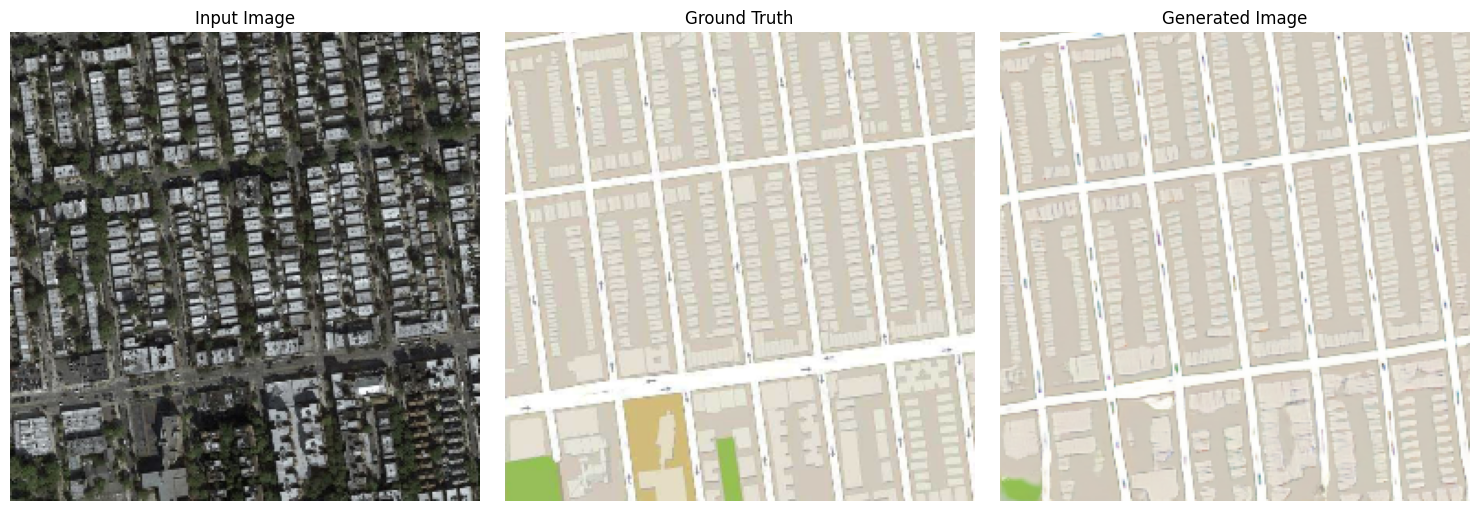

In [35]:
next(gen_map)



### Maps2Aerial


In [36]:
root_dir = root_datasets['maps']

In [37]:
air_dataset = Pix2PixDataset(root_dir, transform=transform_test, is_train = False, swap = True)
air_loader = torch.utils.data.DataLoader(air_dataset, batch_size=1, num_workers=1, shuffle=False)
model_air = Pix2pix(lr_decay_start_epoch=lr_decay_start_epoch,
                num_epochs=N_EPOCHS,
                weight_decay=weight_decay,
                device=device).to(device)

In [38]:
model_air.load_state_dict(torch.load('/content/drive/MyDrive/maps2air_aug'+f"/model_weights_{200}.pth", map_location=torch.device('cpu')))

<All keys matched successfully>

In [39]:
gen_air = show_image(air_loader, model_air, device)

In [40]:
model_air.eval()
None

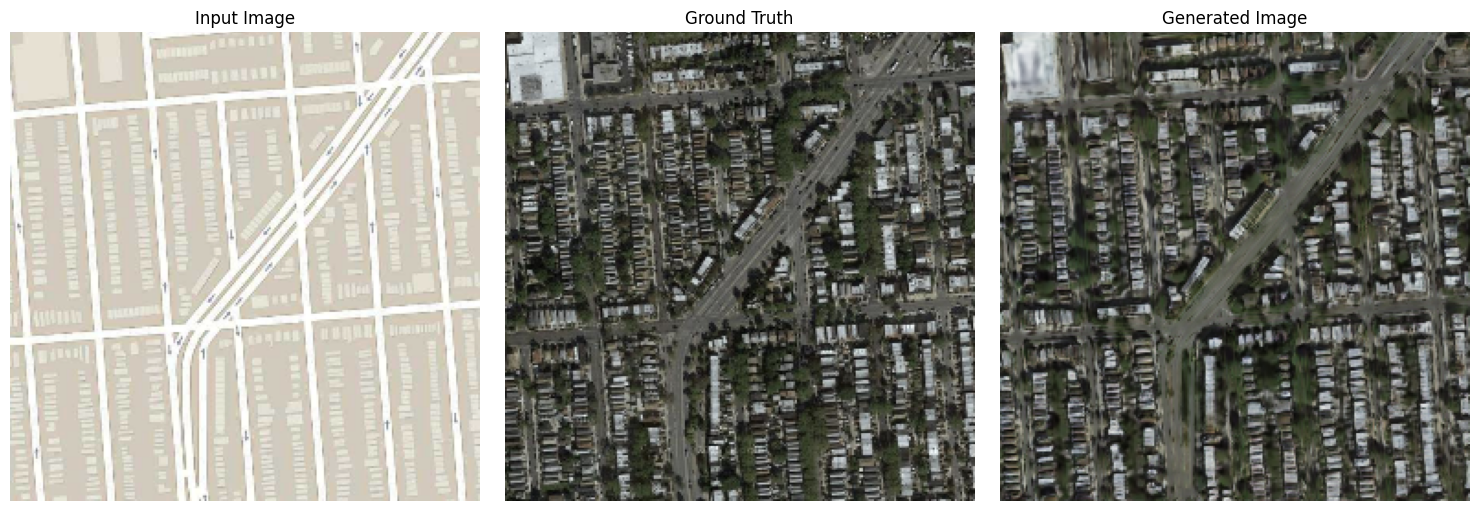

In [41]:
next(gen_air)



### Facades


In [ ]:
root_dir = root_datasets['facades']

In [ ]:
facades_dataset = Pix2PixDataset(root_dir, transform=transform_test, is_train = False, swap = True, to_leak =0.5)
facades_loader = torch.utils.data.DataLoader(facades_dataset, batch_size=1, num_workers=1, shuffle=False)
model_facades = Pix2pix(lr_decay_start_epoch=lr_decay_start_epoch,
                num_epochs=N_EPOCHS,
                weight_decay=weight_decay,
                device=device).to(device)

In [ ]:
model_facades.load_state_dict(torch.load('/content/drive/MyDrive/facades_aug'+f"/model_weights_{300}.pth", map_location=torch.device('cpu')))

<All keys matched successfully>

In [ ]:
model_facades.eval()
None

In [ ]:
gen_facades = show_image(facades_loader, model_facades, device)

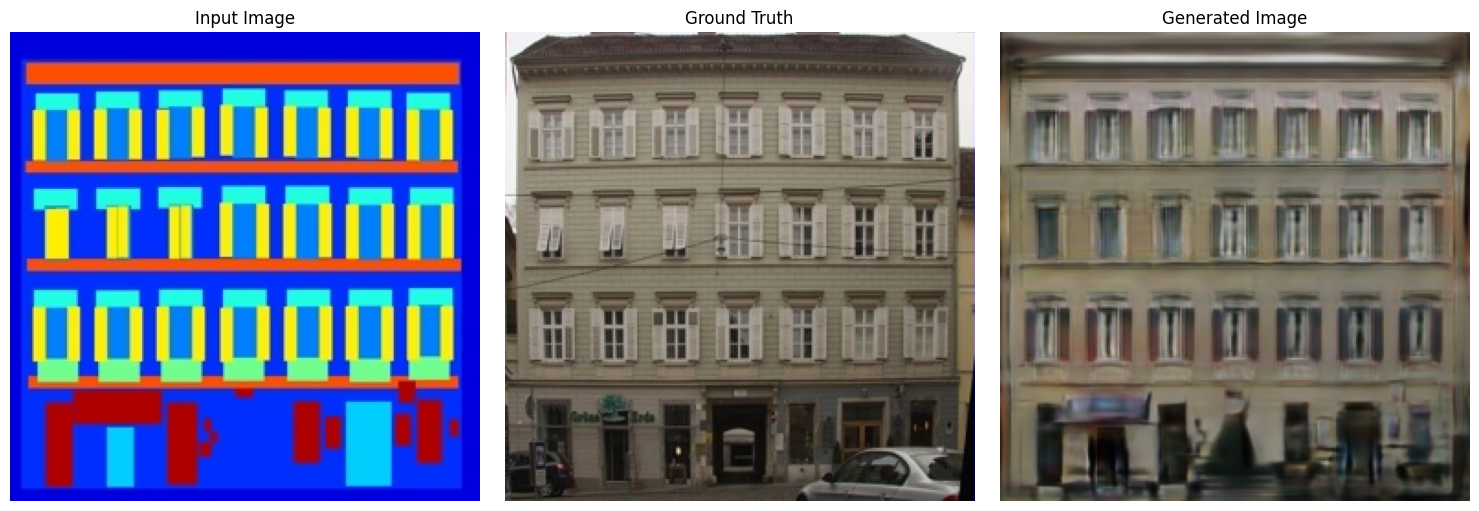

In [ ]:
next(gen_facades)



### Edges2Bags


In [ ]:
root_dir = root_datasets['edges2bags']

In [ ]:
ed2b_dataset = Pix2PixDataset('/content/drive/MyDrive/datasets/edges2handbags', transform=transform_test, is_train = False, swap = False, to_leak = 0)
ed2b_loader = torch.utils.data.DataLoader(ed2b_dataset, batch_size=1, num_workers=1, shuffle=False)
model_ed2b = Pix2pix(lr_decay_start_epoch=lr_decay_start_epoch,
                num_epochs=N_EPOCHS,
                weight_decay=weight_decay,
                device=device).to(device)

In [ ]:
model_ed2b.load_state_dict(torch.load('/content/drive/MyDrive/ed2b_aug'+f"/model_weights_{15}.pth", map_location=torch.device('cpu')))

<All keys matched successfully>

In [ ]:
model_ed2b.eval()
None

In [ ]:
gen_ed2b = show_image(ed2b_loader, model_ed2b, device)

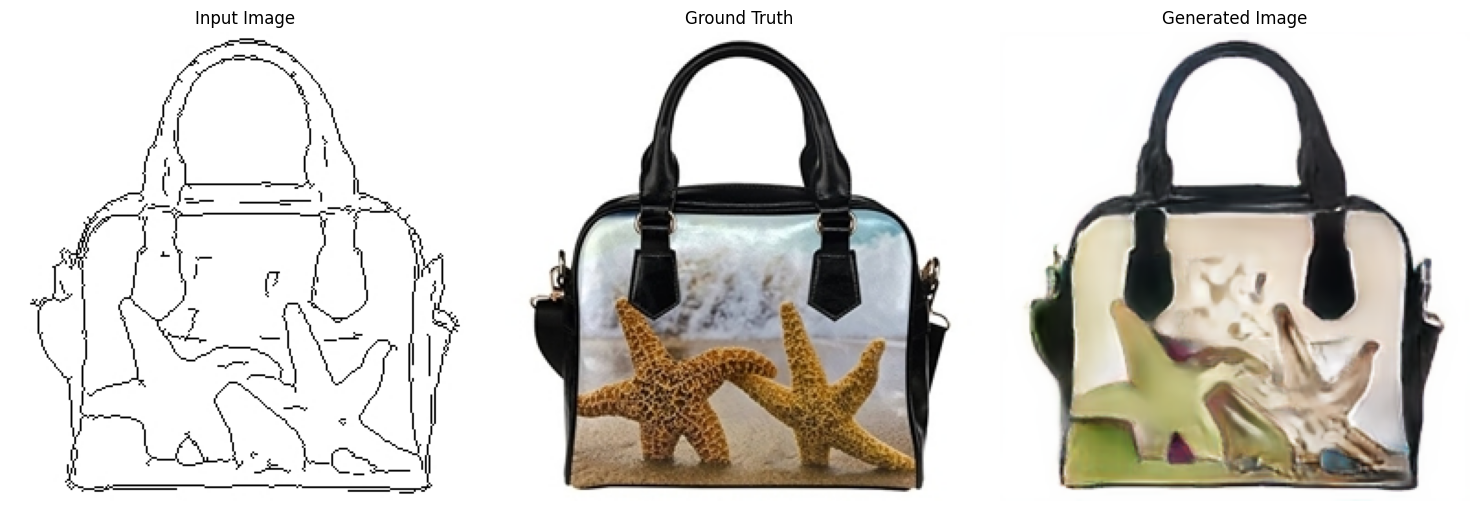

In [ ]:
next(gen_ed2b)



### Edges2Shoes


In [ ]:
root_dir = root_datasets['edges2shoes']

In [ ]:
ed2s_dataset = Pix2PixDataset('/content/drive/MyDrive/datasets/edges2shoes', transform=transform_test, is_train = False, swap = False, to_leak = 0)
ed2s_loader = torch.utils.data.DataLoader(ed2s_dataset, batch_size=1, num_workers=1, shuffle=False)
model_ed2s = Pix2pix(lr_decay_start_epoch=lr_decay_start_epoch,
                num_epochs=N_EPOCHS,
                weight_decay=weight_decay,
                device=device).to(device)

In [ ]:
model_ed2s.load_state_dict(torch.load('/content/drive/MyDrive/ed2sh_aug'+f"/model_weights_{50}.pth", map_location=torch.device('cpu')))

<All keys matched successfully>

In [ ]:
model_ed2s.eval()
None

In [ ]:
gen_ed2s = show_image(ed2s_loader, model_ed2s, device)

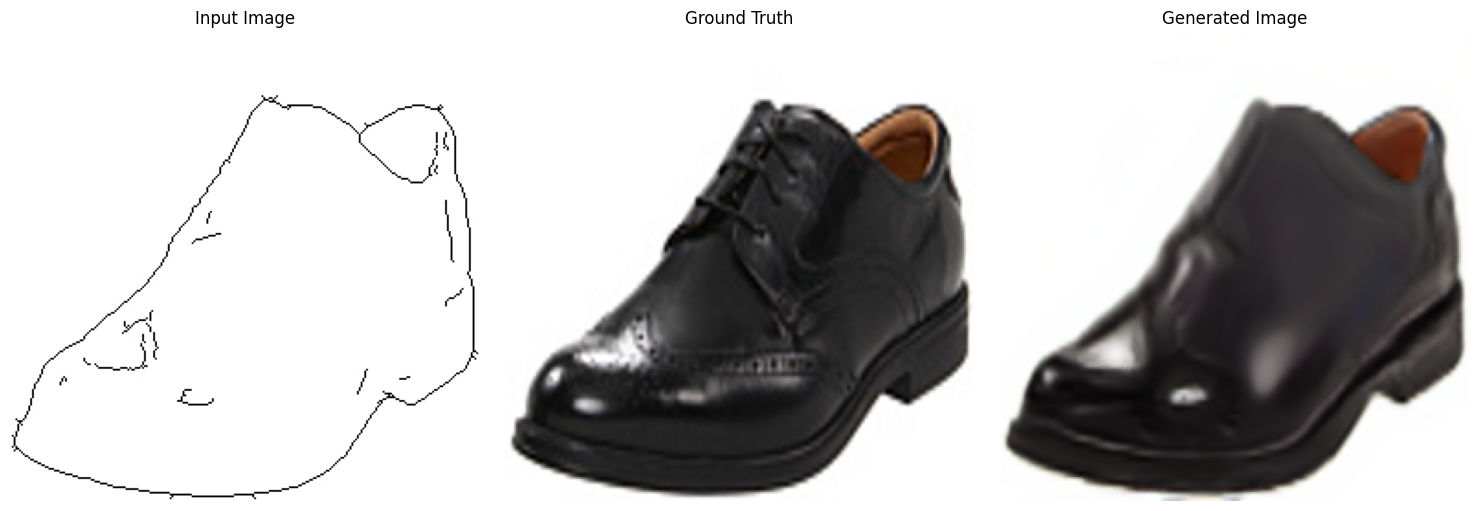

In [ ]:
next(gen_ed2s)



### Cityscapes


In [ ]:
root_dir = root_datasets['cityscapes']

In [ ]:
cityscapes_dataset = Pix2PixDataset(root_dir, transform=transform_test, swap = True, to_leak = 0)
cityscapes_loader = torch.utils.data.DataLoader(cityscapes_dataset, batch_size=1, num_workers=1, shuffle=False)
model_cityscapes = Pix2pix(lr_decay_start_epoch=lr_decay_start_epoch,
                num_epochs=N_EPOCHS,
                weight_decay=weight_decay,
                device=device).to(device)

In [ ]:
model_cityscapes.load_state_dict(torch.load("/content/drive/MyDrive/cityscape_aug/model_weights_300.pth", map_location=torch.device('cpu')))

<All keys matched successfully>

In [ ]:
model_cityscapes.eval()
None

In [ ]:
gen_cityscapes = show_image(cityscapes_loader, model_cityscapes, device)

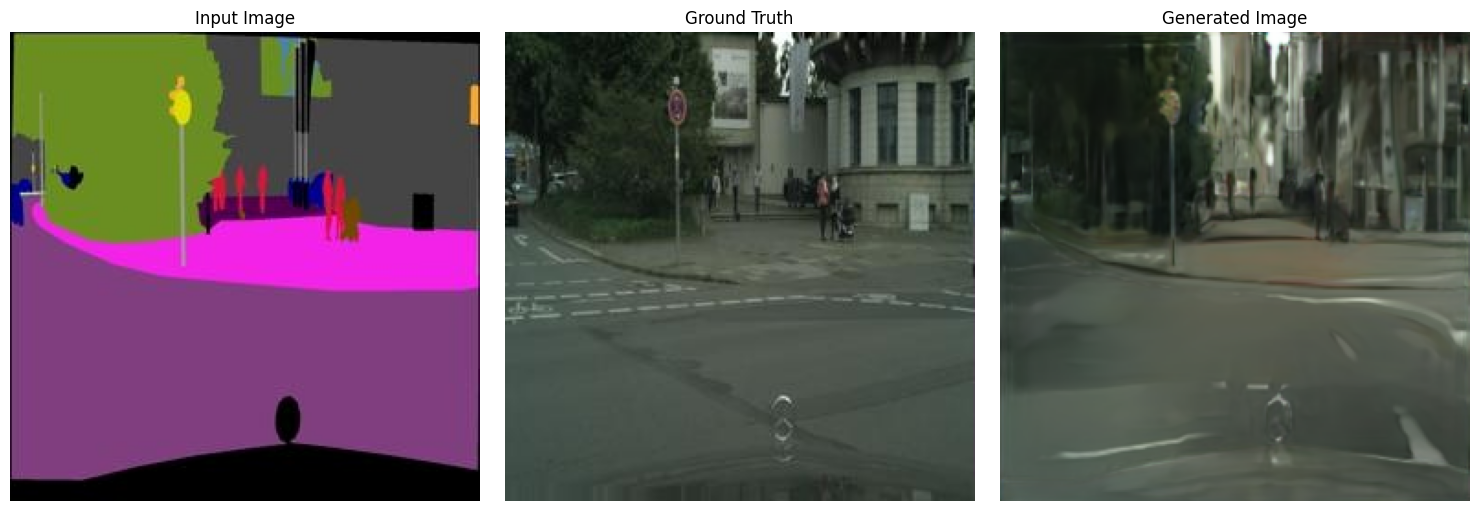

In [ ]:
next(gen_cityscapes)



### Cityscapes


In [ ]:
root_dir = root_datasets['cityscapes']

In [ ]:
cityscapeseg_dataset = Pix2PixDataset(root_dir, transform=transform_test, swap = False, to_leak = 0)
cityscapeseg_loader = torch.utils.data.DataLoader(cityscapeseg_dataset, batch_size=1, num_workers=1, shuffle=False)
model_cityscapeseg = Pix2pix(lr_decay_start_epoch=lr_decay_start_epoch,
                num_epochs=N_EPOCHS,
                weight_decay=weight_decay,
                device=device).to(device)

In [ ]:
model_cityscapeseg.load_state_dict(torch.load("/content/drive/MyDrive/cityscape_seg/model_weights_300.pth", map_location=torch.device('cpu')))

<All keys matched successfully>

In [ ]:
model_cityscapeseg.eval()
None

In [ ]:
gen_cityscapeseg = show_image(cityscapeseg_loader, model_cityscapeseg, device)

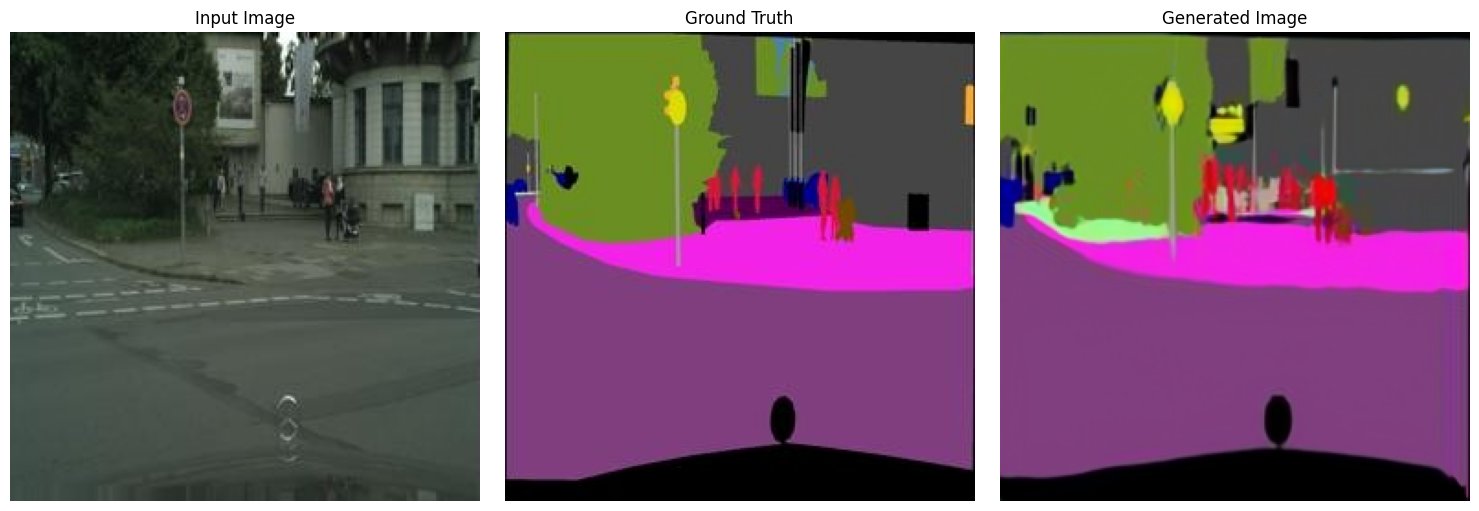

In [ ]:
next(gen_cityscapeseg)



### L1 vs L1+cGAN


In [43]:
root_dir = root_datasets['maps']

In [44]:
model_mapsl1 = Pix2pix(lr_decay_start_epoch=lr_decay_start_epoch,
                num_epochs=N_EPOCHS,
                weight_decay=weight_decay,
                device=device).to(device)

In [45]:
model_mapsl1.load_state_dict(torch.load("/content/drive/MyDrive/maps_l1/model_weights_200.pth", map_location=torch.device('cpu')))

<All keys matched successfully>

In [52]:
model_mapsl1.eval()
None

In [56]:
def show_image2(loader, model1, model2, device):
    # model_maps.eval()
    for x, y in loader:
        fig, ax = plt.subplots(1, 4, figsize=(16, 5))
        with torch.no_grad():
        # Список для изображений
          gen_ten1 = model1.generator(x.to(device))
          gen_ten2 = model2.generator(x.to(device))
          images = [
              (tensor_to_image(x.squeeze(0)), "Input Image"),
              (tensor_to_image(y.squeeze(0)), "Ground Truth"),
              (tensor_to_image(gen_ten1), "L1"),
              (tensor_to_image(gen_ten2), "L1+cGAN")
          ]

        # Отображаем каждое изображение
        for i, (img, label) in enumerate(images):
            ax[i].imshow(img)
            ax[i].axis('off')
            ax[i].set_title(label)

        # Показываем результат
        plt.tight_layout()
        plt.show()

        # Ожидаем следующий батч
        yield

In [57]:
gen_l1 = show_image2(maps_loader, model_mapsl1, model_maps, device)

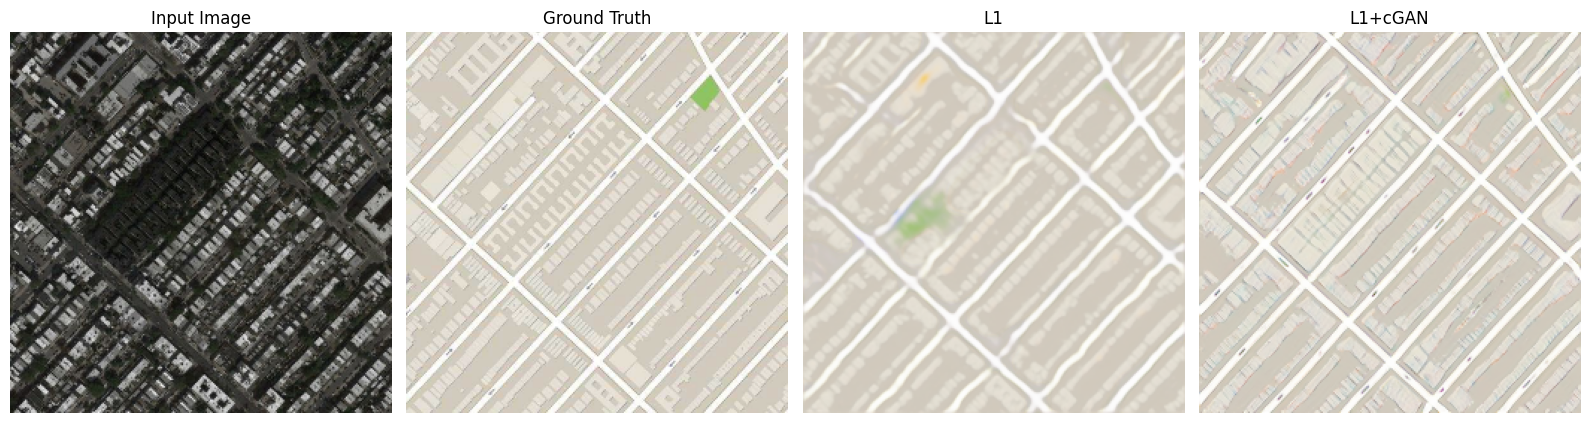

In [58]:
next(gen_l1)